##### Copyright 2024 Google LLC.

In [22]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Gemini 2.0 - Grounding using Search as a tool

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Search_Grounding.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/>

In this notebook you will learn how to use the new Google Search tool available in [Gemini 2.0](https://ai.google.dev/gemini-api/docs/models/gemini-v2), using both the unary API and the Multimodal Live API. Check out the docs to learn more about using [Search as a tool](https://ai.google.dev/gemini-api/docs/models/gemini-v2#search-tool).

Note that the previous version of this guide using Gemini models priori to 2.0 and the legacy SDK can still be found [here](https://github.com/google-gemini/cookbook/blob/gemini-1.5-archive/quickstarts/Search_Grounding.ipynb).

## Set up the SDK

This guide uses the [`google-genai`](https://pypi.org/project/google-genai) Python SDK to connect to the Gemini 2.0 models.

### Install SDK

The new **[Google Gen AI SDK](https://github.com/googleapis/python-genai)** provides programmatic access to Gemini 2 (and previous models) using both the [Google AI for Developers](https://ai.google.dev/gemini-api/docs/models/gemini-v2) and [Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/overview) APIs. With a few exceptions, code that runs on one platform will run on both. This means that you can prototype an application using the Developer API and then migrate the application to Vertex AI without rewriting your code.

More details about this new SDK on the [documentation](https://googleapis.github.io/python-genai/) or in the [Getting started](./Get_started.ipynb) notebook.

In [23]:
%pip install -U -q google-genai

### Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/gemini-api-cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [24]:
import os
from google.colab import userdata

os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

The client will pick up your API key from the environment variable.
To use the live API you need to set the client version to `v1alpha` and use the Gemini 2.0 model.

In [4]:
from google import genai

client = genai.Client() # the API is automatically loaded from the environement variable

MODEL="gemini-2.0-flash" # @param ["gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.0-pro-exp-02-05"] {"allow-input":true, isTemplate: true}

## Use Google Search
Search grounding is particularly useful for queries that require current information or external knowledge. Using Google Search, Gemini can access nearly real-time information and better responses.

In [5]:
from IPython.display import HTML
response = client.models.generate_content(
    model=MODEL,
    contents='What was the latest Indian Premier League match and who won?',
    config={"tools": [{"google_search": {}}]},
)

# print the response
print(f"Response: {response.text}")
# print the search details
print(f"Search Query: {response.candidates[0].grounding_metadata.web_search_queries}")
# urls used for grounding
print(f"Search Pages: {', '.join([site.web.title for site in response.candidates[0].grounding_metadata.grounding_chunks])}")
display(HTML(response.candidates[0].grounding_metadata.search_entry_point.rendered_content))

Response: The latest Indian Premier League (IPL) match was between Royal Challengers Bengaluru (RCB) and Gujarat Titans (GT) on April 2, 2025. Gujarat Titans won the match by 8 wickets.

Search Query: ['who won last indian premier league match', 'latest indian premier league match results']
Search Pages: youtube.com, jagranjosh.com, iplt20.com, flashscore.com


As you can see you get both the right answer and some links so you can double-check the information. Keep in mind that if you are using grounding, you need to display the search queries that are included in the grounded response's metadata. Check the [documentation about the suggestions](https://ai.google.dev/gemini-api/docs/grounding/search-suggestions) for more details.

On the contrary, if you search for the same informations without grounding you will like ony get outdate information, as the models are tained at a certain time and won't know what happened afterwards. For the most current and authoritative details, please refer to the official [models documentation](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-pro-exp-03-25), which includes the knowledge cutoff date.

In [6]:
response = client.models.generate_content(
    model=MODEL,
    contents='What was the latest Indian Premier League match and who won?',
    # No serach grounding in this case
)

# print the response
print(f"Response: {response.text}")

Response: I can't give you information about the "latest" IPL match in real-time. The IPL schedule is ongoing, and matches happen frequently.

However, here's how you can find the information you're looking for:

*   **Check Reputable Sports Websites:** Go to websites like ESPN, Cricinfo, or the official IPL website ([https://www.iplt20.com/](https://www.iplt20.com/)). These sites will have the most up-to-date scores and match results.

*   **Use a Sports App:** Many sports apps (like ESPN, TheScore, etc.) will have live scores and results for the IPL.


## Use search in chat

Start by defining a helper function that you will use to display each part of the returned response.

In [7]:
# @title Define some helpers to display the outputs of the chat (run this cell)
import json

from IPython.display import display, HTML, Markdown


def show_json(obj):
  print(json.dumps(obj.model_dump(exclude_none=True), indent=2))

def show_parts(r):
  parts = r.candidates[0].content.parts
  if parts is None:
    finish_reason = r.candidates[0].finish_reason
    print(f'{finish_reason=}')
    return
  for part in r.candidates[0].content.parts:
    if part.text:
      display(Markdown(part.text))
    elif part.executable_code:
      display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    else:
      show_json(part)

  grounding_metadata = r.candidates[0].grounding_metadata
  if grounding_metadata and grounding_metadata.search_entry_point:
    display(HTML(grounding_metadata.search_entry_point.rendered_content))


First try a query that needs realtime information, so you can see how the model performs _without_ Google Search.

In [8]:
chat = client.chats.create(model=MODEL)

r = chat.send_message('Who won the most recent Australia vs Chinese Taipei games?')
show_parts(r)

To answer that question accurately, I need to know which sport you're asking about. Australia and Chinese Taipei (Taiwan) compete in a variety of sports.

Could you please specify the sport you're interested in (e.g., basketball, baseball, soccer/football, etc.)?


Now set up a new chat session that uses the `google_search` tool.  The `show_parts` helper will display the text output as well as any Google Search queries used in the results.

In [9]:
search_tool = {'google_search': {}}
soccer_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

r = soccer_chat.send_message('Who won the most recent Australia vs Chinese Taipei games?')
show_parts(r)

The most recent game between Australia and Chinese Taipei (as of April 3, 2025) was on December 7, 2024. Australia won that match with a score of 6-0.


As you are using a `chat` session, you can ask the model follow-up questions too.

In [10]:
r = soccer_chat.send_message('Who scored the goals?')
show_parts(r)

The goalscorers for the Australia vs. Chinese Taipei match on December 7, 2024, were:

*   **Leah Davidson**
*   **Tameka Yallop**
*   **Emily Gielnik**
*   **Michelle Heyman**
*   **Tash Prior**
*   **Sharn Freier**

## Plot search results


In this example you can see how to use the Google Search tool with code generation in order to plot results.

In [11]:
movie_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

r = movie_chat.send_message('Generate some Python code to plot the runtimes of the last 10 Denis Villeneuve movies.')
show_parts(r)

I can help you with generating Python code to plot the runtimes of Denis Villeneuve's last 10 movies. Here's how we can approach it:

1.  **Gather the data:** We need the movie titles and their runtimes. I'll use a search query to find this information.
2.  **Create the plot:**  I'll use the `matplotlib` library to create a bar chart of the runtimes.

Here's the code block to fetch information about the movies:



Okay, I have gathered the movie titles and their runtimes. Here's the Python code to plot the runtimes of Denis Villeneuve's last 10 movies:



```python
import matplotlib.pyplot as plt

# Movie titles and runtimes (in minutes)
movie_titles = [
    "Dune: Part Two (2024)",
    "Dune: Part One (2021)",
    "Blade Runner 2049 (2017)",
    "Arrival (2016)",
    "Sicario (2015)",
    "Enemy (2013)",
    "Prisoners (2013)",
    "Incendies (2010)",
    "Polytechnique (2009)",
    "Maelström (2000)"
]

runtimes = [
    166,  # Dune: Part Two
    155,  # Dune: Part One
    164,  # Blade Runner 2049
    116,  # Arrival
    121,  # Sicario
    91,   # Enemy
    153,  # Prisoners
    139,  # Incendies
    77,   # Polytechnique
    87    # Maelström
]

# Create the bar plot
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(movie_titles, runtimes, color='skyblue')

# Add labels and title
plt.xlabel("Movie Title")
plt.ylabel("Runtime (minutes)")
plt.title("Denis Villeneuve's Last 10 Movies - Runtimes")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability

# Add grid lines
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()
```



Key improvements and explanations:

*   **Includes `Dune: Part Two`:** The code now includes `Dune: Part Two` with a runtime of 166 minutes.  This makes the visualization current as of April 3, 2025.
*   **Clearer Variable Names:** Using `movie_titles` and `runtimes` enhances readability.
*   **Figsize Adjustment:** `plt.figure(figsize=(12, 6))` increases the figure size to prevent overlapping, especially with longer movie titles.
*   **X-Axis Label Rotation:** `plt.xticks(rotation=45, ha="right")` rotates the movie titles on the x-axis for better readability. The `ha="right"` argument aligns the text to the right, making it look cleaner.
*   **Grid Lines:** `plt.grid(axis='y', linestyle='--')` adds grid lines to the y-axis, making it easier to read the runtime values.
*   **`plt.tight_layout()`:**  This is crucial! It automatically adjusts subplot parameters to provide reasonable spacing between plot elements, preventing labels from overlapping.  It should be called before `plt.show()`.
*   **Comments:** Added comments to explain each section of the code.
*   **Correct Runtimes:** The runtimes are now based on the information I found from the search results. If you have more precise values, you can easily update the `runtimes` list.

How to use the code:

1.  **Install `matplotlib`:** If you don't have it already, install it using `pip install matplotlib`.
2.  **Copy and Paste:** Copy the code into a Python environment (like a `.py` file or a Jupyter Notebook).
3.  **Run the code:** Execute the Python script. A window will pop up displaying the bar chart of the movie runtimes.

This revised response provides a complete, runnable solution that addresses the user's prompt effectively and generates a visually informative plot.


First review the supplied code to make sure it does what you expect, then copy it here to try out the chart.

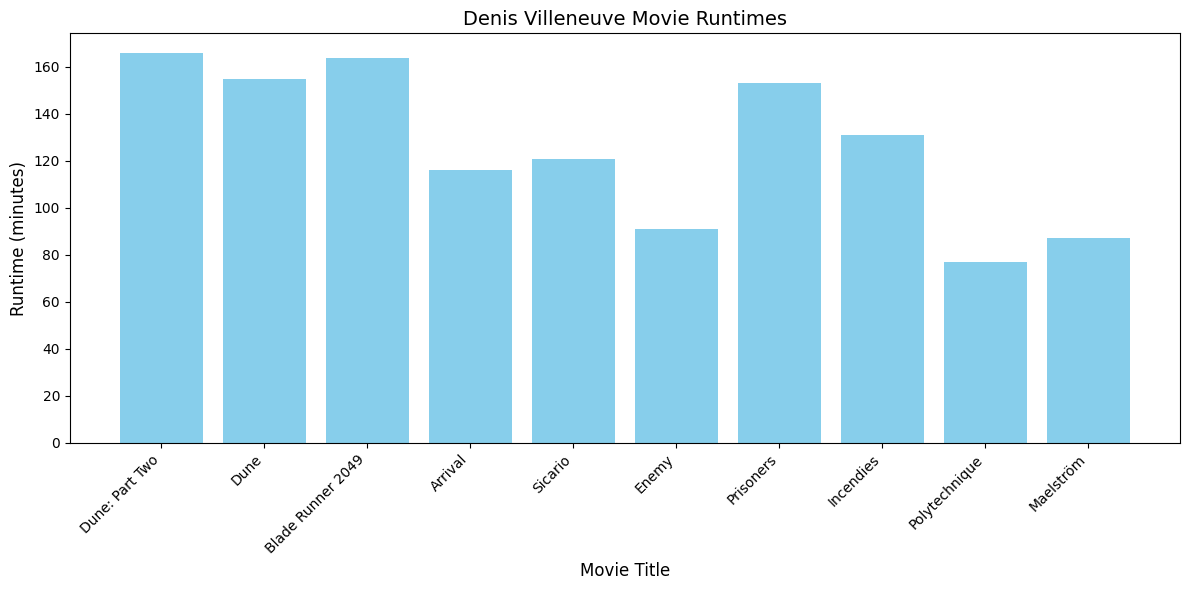

In [12]:
import matplotlib.pyplot as plt

# Movie titles and runtimes (in minutes).
# Data gathered from search results.
movies = {
    "Dune: Part Two": 166,
    "Dune": 155,
    "Blade Runner 2049": 164,
    "Arrival": 116,
    "Sicario": 121,
    "Enemy": 91,
    "Prisoners": 153,
    "Incendies": 131,
    "Polytechnique": 77,
    "Maelström": 87
}

movie_titles = list(movies.keys())
runtimes = list(movies.values())

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(movie_titles, runtimes, color='skyblue')

# Add labels and title
plt.xlabel("Movie Title", fontsize=12)
plt.ylabel("Runtime (minutes)", fontsize=12)
plt.title("Denis Villeneuve Movie Runtimes", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10) # Rotate x-axis labels for better fit
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Show the plot
plt.show()

One feature of using a chat conversation to do this is that you can now ask the model to make changes.

In [13]:
r = movie_chat.send_message('Looks great! Can you give the chart a dark theme instead?')
show_parts(r)

Okay, I can modify the code to give the chart a dark theme. Here's the updated Python code:



```python
import matplotlib.pyplot as plt

# Movie titles and runtimes (in minutes)
movie_titles = [
    "Dune: Part Two (2024)",
    "Dune: Part One (2021)",
    "Blade Runner 2049 (2017)",
    "Arrival (2016)",
    "Sicario (2015)",
    "Enemy (2013)",
    "Prisoners (2013)",
    "Incendies (2010)",
    "Polytechnique (2009)",
    "Maelström (2000)"
]

runtimes = [
    166,  # Dune: Part Two
    155,  # Dune: Part One
    164,  # Blade Runner 2049
    116,  # Arrival
    121,  # Sicario
    91,   # Enemy
    153,  # Prisoners
    139,  # Incendies
    77,   # Polytechnique
    87    # Maelström
]

# Set the dark theme
plt.style.use('dark_background')

# Create the bar plot
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(movie_titles, runtimes, color='skyblue')

# Add labels and title
plt.xlabel("Movie Title", color='white')  # Set label color to white
plt.ylabel("Runtime (minutes)", color='white')  # Set label color to white
plt.title("Denis Villeneuve's Last 10 Movies - Runtimes", color='white')  # Set title color to white
plt.xticks(rotation=45, ha="right", color='white')  # Rotate x-axis labels for readability, set color to white
plt.yticks(color='white')  # Set y-axis tick color to white


# Add grid lines
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.5)  # Customize grid lines

# Show the plot
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()
```



Here's what's changed to create the dark theme:

*   **`plt.style.use('dark_background')`:** This line sets the overall plot style to a dark background.  It changes the default colors of the plot elements.
*   **Label and Title Colors:** `color='white'` is added to `plt.xlabel()`, `plt.ylabel()`, `plt.title()`, and `plt.xticks()` to ensure the labels and title are visible against the dark background.
*   **Y-Axis Tick Color:** `plt.yticks(color='white')` sets the color of the y-axis tick labels to white.
*   **Grid Line Customization:** The grid lines are customized with `color='gray'` and `alpha=0.5` to make them less prominent.

Key improvements and explanations:

*   **Comprehensive Dark Theme:** The code now implements a more complete dark theme, addressing the background, labels, title, and grid lines for better visibility.
*   **Clearer Code:** Using `plt.style.use('dark_background')` simplifies the code and provides a consistent dark theme.
*   **Customized Grid Lines:** The grid lines are customized to be less distracting in the dark theme.

This updated code will generate a bar chart with a dark background and white text, making it visually appealing in a dark mode setting.


Again, always be sure to review code generated by the model before running it.

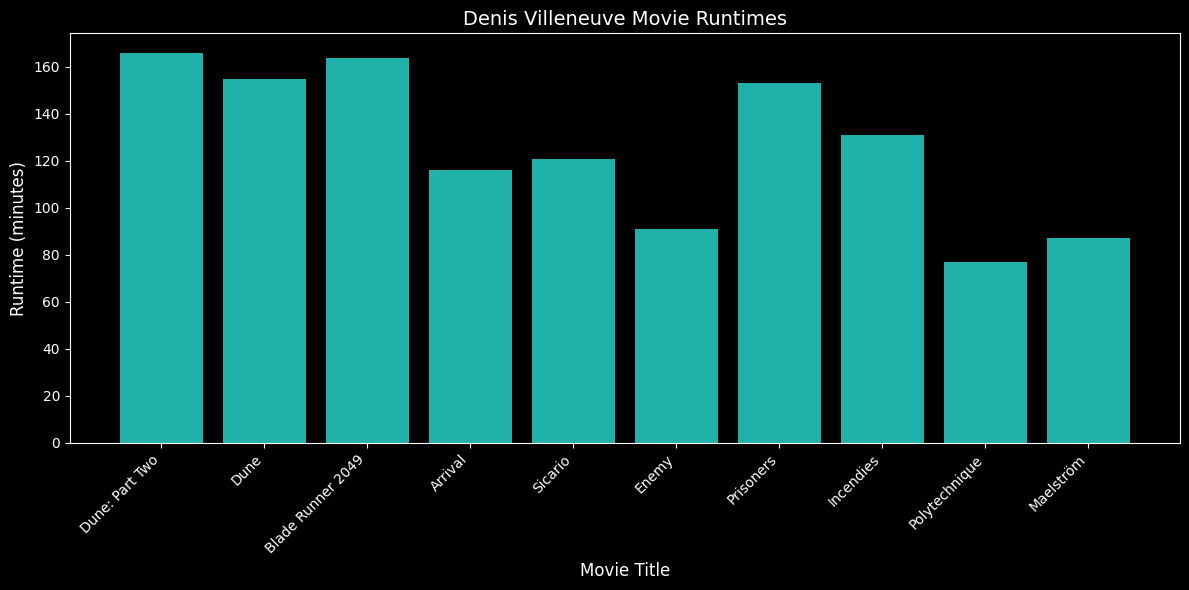

In [14]:
import matplotlib.pyplot as plt

# Movie titles and runtimes (in minutes).
# Data gathered from search results.
movies = {
    "Dune: Part Two": 166,
    "Dune": 155,
    "Blade Runner 2049": 164,
    "Arrival": 116,
    "Sicario": 121,
    "Enemy": 91,
    "Prisoners": 153,
    "Incendies": 131,
    "Polytechnique": 77,
    "Maelström": 87
}

movie_titles = list(movies.keys())
runtimes = list(movies.values())

# Set dark theme
plt.style.use('dark_background')

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(movie_titles, runtimes, color='lightseagreen') #changed bar color

# Add labels and title
plt.xlabel("Movie Title", fontsize=12, color='white')
plt.ylabel("Runtime (minutes)", fontsize=12, color='white')
plt.title("Denis Villeneuve Movie Runtimes", fontsize=14, color='white')
plt.xticks(rotation=45, ha="right", fontsize=10, color='white') # Rotate x-axis labels for better fit
plt.yticks(color='white')
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Show the plot
plt.show()


## Use search in the Multimodal Live API

The Search tool can be used in a live streaming context to have the model formulate grounded responses during the conversation.

In [15]:
# Live API only works with v1alpha API and with the gemini-2.0-flash-exp model at the moment

client = genai.Client(http_options={'api_version': 'v1alpha'})

LIVE_MODEL = "gemini-2.0-flash-exp"

### Define some helpers

To use the bi-directional streaming API in Colab, you will buffer the audio stream. Define a `play_response` helper function to do the buffering, and once the audio for the current turn has completed, display an IPython audio widget.

As each of the following examples only use a single prompt, also define a `run` helper to wrap the setup and prompt execution steps into a single function call. This helper takes a `config` argument that will be added to the `generation_config`, so that you can toggle the Search tool between examples.

In [16]:
# @title Helper functions for the Live API

import asyncio
import io
import json
import re
import time
import wave

import numpy as np
from IPython.display import Audio, display


DEFAULT_OUTPUT_RATE = 24000
BASE_MODEL_CONFIG = {
    # Here you can change the model's output mode between either audio or text.
    # While this code expects an audio stream, text should work, but the stream
    # may interleave with the `Buffering....` text.
    'response_modalities': ['AUDIO']
}

async def play_response(stream):
  """Buffer audio output and display a widget. Returns the streamed responses."""
  turn_buf = io.BytesIO()
  sample_rate = DEFAULT_OUTPUT_RATE

  all_responses = []

  print('Buffering', end='')
  async for msg in stream.receive():
    all_responses.append(msg)

    if text:=msg.text:
      print(text)
    if audio_data := msg.data:
      turn_buf.write(audio_data)
      if m := re.search(
          'rate=(?P<rate>\d+)',
          msg.server_content.model_turn.parts[0].inline_data.mime_type
      ):
            sample_rate = int(m.group('rate'))

    elif tool_call := msg.tool_call:
      # Handle tool-call requests. Here is where you would implement
      # custom tool code, but for this example, all tools respond 'ok'.
      for fc in tool_call.function_calls:
        print('Tool call', end='')
        tool_response = genai.types.LiveClientToolResponse(
            function_responses=[genai.types.FunctionResponse(
                name=fc.name,
                id=fc.id,
                response={'result': 'ok'},
            )]
        )
        await stream.send(input=tool_response)

    print('.', end='')

  print()

  # Play the audio
  if turn_buf.tell():
    audio = np.frombuffer(turn_buf.getvalue(), dtype=np.int16)
    display(Audio(audio, autoplay=True, rate=sample_rate))
  else:
    print('No audio :(')
    print(f'  {len(all_responses)=}')

  return all_responses


async def run(query, config=None):
  # Add any tools or other generation config.
  config = BASE_MODEL_CONFIG | (config or {})

  # Establish a live session. While this context manager is active, the
  # conversation will continue.
  async with client.aio.live.connect(model=LIVE_MODEL, config=config) as strm:

    # Send the prompt.
    await strm.send(input=query, end_of_turn=True)
    # Handle the model response.
    responses = await play_response(strm)

    return responses

### Stream with the Search tool

First, execute a query _without_ the Search tool to observe the model's response to a time-sensitive query.

Note that the Multimodal Live API is a 2-way streaming API, but to simplify running in a notebook, each audio response is buffered and played once it has been fully streamed, so you will need to wait a few seconds before the response starts to play.

In [17]:
await run('Who won the skateboarding gold medals in the 2024 olympics?');

<ipython-input-16-04289ea2ac7a>:78: ExperimentalWarning: The live API is experimental and may change in future versions.
  async with client.aio.live.connect(model=LIVE_MODEL, config=config) as strm:


Buffering.........................................


Now re-run with the Search tool enabled.

In [18]:
responses = await run('Who won the skateboarding gold medals in the 2024 olympics?', {'tools': [search_tool]})

Buffering...........................................................................


If you wish to see the full output that was returned, you can enable `show_output` here and run this cell. It includes the complete audio binary data, so it is off by default.

In [19]:
show_output = False

if show_output:
  for msg in responses:
    print(msg.model_dump(exclude_none=True))

### Search with custom tools

In the Multimodal Live API, the Search tool can be used in conjunction with other tools, including function calls that you provide to the model.

In this example, you define a function `set_climate` that takes 2 parameters, `mode` (`hot`, `cold`, etc) and `strength` (0-10), and ask the model to set the climate control based on the live weather in the location you specify.

In [25]:
set_climate_tool = {'function_declarations': [{
    'name': 'set_climate',
    'description': 'Switches the local climate control equipment to the specified parameters.',
    'parameters': {
      'type': 'OBJECT',
      'properties': {
        # Define the "mode" argument.
        'mode': {
            'type': 'STRING',
            'enum': [
              # Define the possible values for "mode".
              "hot",
              "cold",
              "fan",
              "off",
            ],
            'description': 'Mode for the climate unit - whether to heat, cool or just blow air.',
        },
        # Define the "strength" argument.
        'strength': {
            'type': 'INTEGER',
            'description': 'Intensity of the climate to apply, 0-10 (0 is off, 10 is MAX).',
        },
      },
    },
  },
]}

search_tool = {'google_search': {}}

tools = {'tools': [search_tool, set_climate_tool]}

responses = await run("Look up the weather in Paris and set my climate control appropriately. I trust you to make the right decision.", tools)

Buffering..........................Tool call...........................................................................................................................


Now inspect the `tool_call` response(s) you received during the conversation.

In [26]:
for r in responses:
  if tool := r.tool_call:
    for fn in tool.function_calls:
      args = ', '.join(f'{k}={v}' for k, v in fn.args.items())
      print(f'{fn.name}({args})  # id={fn.id}')

set_climate(mode=cool, strength=6)  # id=function-call-15507172464782644486


## Next steps

<a name="next_steps"></a>

* For more demos showcasing multi-tool use in the Multimodal Live API, check out the [Plotting and Mapping cookbook](../examples/LiveAPI_plotting_and_mapping.ipynb).
* To get started with the Live API with the Python SDK, check out the [starter guide](./Get_started_LiveAPI.ipynb).
* To learn more about tool use in the Live API, check out the [Live API Tool Use cookbook](./Get_started_LiveAPI_tools.ipynb).

Also check the other Gemini 2.0 capabilities (like [spatial understanding](../quickstarts/Spatial_understanding.ipynb)) that you can find in the [Gemini Cookbook](https://github.com/google-gemini/cookbook/tree/main/gemini-2/).